In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import OrderedDict
import xgboost as xgb
import pickle
import rebound
import matplotlib.pyplot as plt
%matplotlib inline  


# if a collision occurs, end the simulation
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0

# To generate your own features that can be passed to the model to generate predictions 
# from your simulations, you need to use/copy the function "generate_features" from here - 
# https://github.com/Naireen/MLstability/blob/orbelements/generate_features/generatefeaturesscriptNoLyaMoreFeats.py - 
# which accepts a rebound simulation (i.e. so make your simulation in an identical manner 
# that you would as if you were going to run on ACI-b, but then pass to this function instead). 


# This version is modified slightly to only look at 3 planets of a four planet 
# system based on which planet is asked to be removed by the remove parameter
def generate_features_4planet(sim, maxorbs=10000, Nout=100, window=10, remove=4):
    
    # Lastly, in the generate_features function there's a few constants you have to hardcode: 
    # maxorbs = 10000 #length of the integration. The model was trained with data integrated for maxorbs orbits for the inner most planet.
    # Nout = 100 #how many data points to output. This means you measure the eccentricities, distances, etc every 100 orbits. 
    # window = 10 #This is to look at the first n points and determine features from just this small subset of the data. You're essentially looking at its initial short term behavior. 
    
    #the base list of what planets features will be generated for. It is essentially a list of the sim particle indices that you want ot use
    mod = [1,2,3]
    
    #shift the indices so that the desired planet is skipped in the later feature generation
    for i in range(3):
        if i>(remove-2):
            mod[i]=mod[i]+1
        mod[i]=int(mod[i])
    
    t0 = time.time()
    ps = sim.particles
    
    P0 = ps[mod[0]].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate
    
    sim.collision_resolve = collision

    #kicksize=1.e-11
    #sim2.particles[2].x += kicksize
    
    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)
    
    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    inc = np.zeros((sim.N,Nout))
    
    #beta = np.zeros((sim.N,Nout))
    beta12 = np.zeros(Nout)
    beta23 = np.zeros(Nout)

    #Rhill=np.zeros((sim.N,sim.N))
    #for x in range(sim.N):
    #    for y in range(sim.N):
    #        if y<x:
    #            Rhill[x,y]=np.mean([a[x],a[y]])*((mlist[x]+mlist[y])*earth/Ms/3.)**(1./3.)
    #            separation[x,y]=abs(a[x]-a[y])/mut_hill[x,y]
    #maxsinglesep=np.max(singlesep)
    #maxdoublesep=np.max(doublesep)
    Rhill12 = ps[mod[0]].a*((ps[mod[0]].m+ps[mod[1]].m)/3.)**(1./3.)
    Rhill23 = ps[mod[1]].a*((ps[mod[1]].m+ps[mod[2]].m)/3.)**(1./3.)
    
    eHill = [0, Rhill12/ps[mod[0]].a, max(Rhill12, Rhill23)/ps[mod[1]].a, Rhill23/ps[mod[2]].a]
    daOvera = [0, (ps[mod[1]].a-ps[mod[0]].a)/ps[mod[0]].a, min(ps[mod[2]].a-ps[mod[1]].a, ps[mod[1]].a-ps[mod[0]].a)/ps[mod[1]].a, (ps[mod[2]].a-ps[mod[1]].a)/ps[mod[2]].a]
    
    for i, t in enumerate(times):
        for j in [1,2,3]:
            a[j,i] = ps[mod[j-1]].a
            e[j,i] = ps[mod[j-1]].e
            inc[j,i] = ps[mod[j-1]].inc

        #need to update rhills?
        Rhill12 = ps[mod[0]].a*((ps[mod[0]].m+ps[mod[1]].m)/3.)**(1./3.)
        Rhill23 = ps[mod[1]].a*((ps[mod[1]].m+ps[mod[2]].m)/3.)**(1./3.)
        
        beta12[i] = (ps[mod[1]].a - ps[mod[0]].a)/Rhill12
        beta23[i] = (ps[mod[2]].a - ps[mod[1]].a)/Rhill23   
        sim.integrate(t)        
        #try:
        #    sim.integrate(t)
        #except:
        #    pass
    
    features = OrderedDict()
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)

    for string, feature in [("beta12", beta12), ("beta23", beta23)]:
        mean = feature.mean()
        std = feature.std()
        features["avg_"+string] = mean
        features["std_"+string] = std
        features["min_"+string] = min(feature)
        features["max_"+string] = max(feature)

    
    for j in [1,2,3]:
        for string, feature in [('a', a), ('e', e), ('inc', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()
            features['avg_'+string+str(j)] = mean
            features['std_'+string+str(j)] = std
            features['max_'+string+str(j)] = feature[j].max()
            features['min_'+string+str(j)] = feature[j].min()
            features['norm_std_'+string+str(j)] = std/mean
            features['norm_max_'+string+str(j)] = np.abs(feature[j] - mean).max()/mean
            sample = feature[j][:window]
            samplemean = sample.mean()
            features['norm_std_window'+str(window)+'_'+string+str(j)] = sample.std()/samplemean
            features['norm_max_window'+str(window)+'_'+string+str(j)] = np.abs(sample - samplemean).max()/samplemean

        for string, feature in [('eH', e), ('iH', inc)]:
            mean = feature[j].mean()
            std = feature[j].std()

            features['avg_'+string+str(j)] = mean/eHill[j]
            features['std_'+string+str(j)] = std/eHill[j]
            features['max_'+string+str(j)] = feature[j].max()/eHill[j]
            features['min_'+string+str(j)] = feature[j].min()/eHill[j]

        string, feature = ('ecross', e)
        features['avg_'+string+str(j)] = mean/daOvera[j]
        features['std_'+string+str(j)] = std/daOvera[j]
        features['max_'+string+str(j)] = feature[j].max()/daOvera[j]
        features['min_'+string+str(j)] = feature[j].min()/daOvera[j]

        xx = range(a[j].shape[0])
        yy = a[j]/a[j].mean()/features["t_final_short"]
        par = np.polyfit(xx, yy, 1, full=True)
        features['norm_a'+str(j)+'_slope'] = par[0][0]

    t = time.time()
    features['wall_time'] = t-t0
    
    return pd.Series(features, index=list(features.keys()))


#convert simulation archive to dataframe
def sa_2_features(sa, remove=4):
    sim=sa[0]
    features_series=generate_features_4planet(sim, remove=remove)
    del sim
    featurescolumns=list(features_series.index)
    featuresvalues=np.array(features_series)
    featuresvalues=featuresvalues.reshape(1,len(featuresvalues))
    features_df=pd.DataFrame(data=featuresvalues, columns=featurescolumns)
    return features_df

In [2]:
#Generating features

systems = ["bully 0.045", "super earth 0.06", "neptune 0.1", "Ari Fake 15 0.09", "analog 0.04", "3.5 planet 0.02"]
system = systems[5]
system = system.replace(" ","_")
Np = 4

testlen=500
total=testlen*Np
tracker=0
# for j in range(Np):
for j in [2,3]:
    for i in range(testlen):
        id_ = int(i)
        name = system+"_"+str(id_)
        if i==0:
            
            sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
            features=sa_2_features(sa, remove=j+1)
            del sa
        
        else:
            
            sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
            features2=sa_2_features(sa, remove=j+1)
            features=pd.concat([features,features2], axis=0)
            del sa
            
        tracker+=1
        if tracker%10==0:
            print("%3.2f%% complete"%(tracker/total*100))
    features.to_csv('features/%s_i%d_features.csv'%(system,j+1))

0.50% complete
1.00% complete
1.50% complete
2.00% complete
2.50% complete
3.00% complete
3.50% complete
4.00% complete
4.50% complete
5.00% complete
5.50% complete
6.00% complete
6.50% complete
7.00% complete
7.50% complete
8.00% complete
8.50% complete
9.00% complete
9.50% complete
10.00% complete
10.50% complete
11.00% complete
11.50% complete
12.00% complete
12.50% complete
13.00% complete
13.50% complete
14.00% complete
14.50% complete
15.00% complete
15.50% complete
16.00% complete
16.50% complete
17.00% complete
17.50% complete
18.00% complete
18.50% complete
19.00% complete
19.50% complete
20.00% complete
20.50% complete
21.00% complete
21.50% complete
22.00% complete
22.50% complete
23.00% complete
23.50% complete
24.00% complete
24.50% complete
25.00% complete
25.50% complete
26.00% complete
26.50% complete
27.00% complete
27.50% complete
28.00% complete
28.50% complete
29.00% complete
29.50% complete
30.00% complete
30.50% complete
31.00% complete
31.50% complete
32.00% comp

In [2]:
feature_list = []
feature_list += ['avg_iH1', 'avg_iH2']
feature_list += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
feature_list += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
feature_list += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
feature_list += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
feature_list += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
feature_list += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
feature_list += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
feature_list += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23']

simulations that ended in 'collision'
[  1   4   5   6   7   8  11  12  13  14  17  18  20  21  22  23  27  28
  30  32  33  34  35  36  37  39  41  43  44  46  52  55  57  58  65  66
  67  70  72  74  75  77  80  81  82  83  84  85  86  87  88  92  93  96
  97 100 101 103 106 108 109 110 111 114 118 119 120 127 128 133 137 139
 142 143 145 147 148 150 151 152 154 155 156 158 159 160 164 165 166 167
 169 172 173 175 177 178 180 183 185 187 188 189 190 191 195 196 198 199
 200 203 204 208 210 211 213 214 216 219 225 226 229 230 231 233 235 236
 237 238 240 241 245 246 247 248 249 253 256 258 263 264 265 266 267 269
 270 271 272 274 276 280 282 285 286 287 291 292 294 295 298 299 300 301
 306 313 314 315 316 318 322 325 326 328 332 335 336 337 339 340 341 343
 345 350 352 353 354 355 356 364 365 368 370 372 374 375 377 378 379 382
 388 389 392 394 395 396 397 399 402 403 404 405 409 412 414 415 416 418
 420 421 422 423 424 425 433 439 440 441 443 444 445 446 447 448 451 455
 456 457 458 

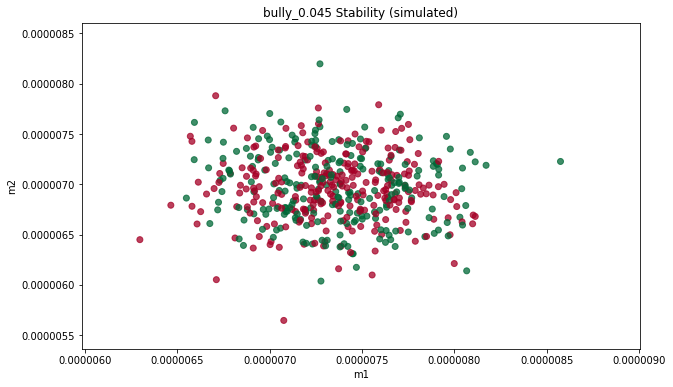

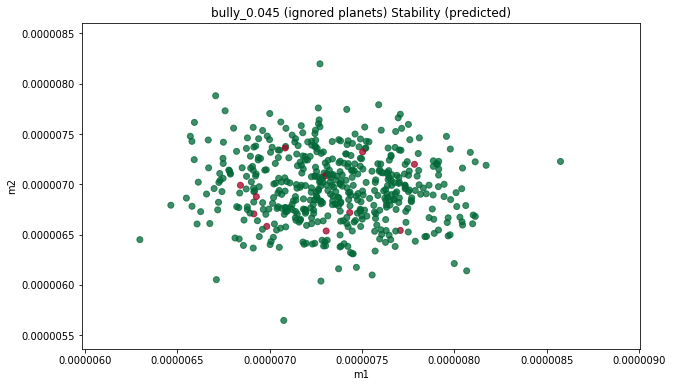

amount of simulated unstable systems
261
amount of predicted unstable systems
11


/storage/home/cjg66/anaconda3/envs/ml-stab/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in long_scalars


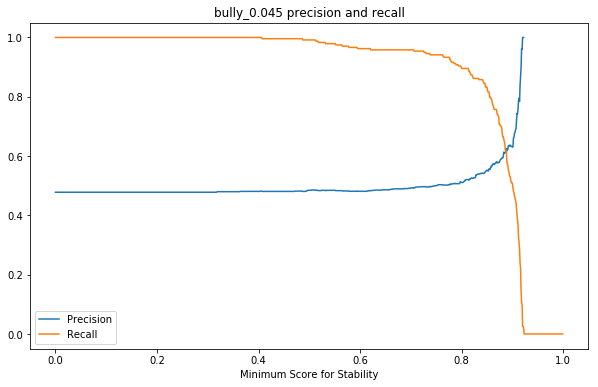

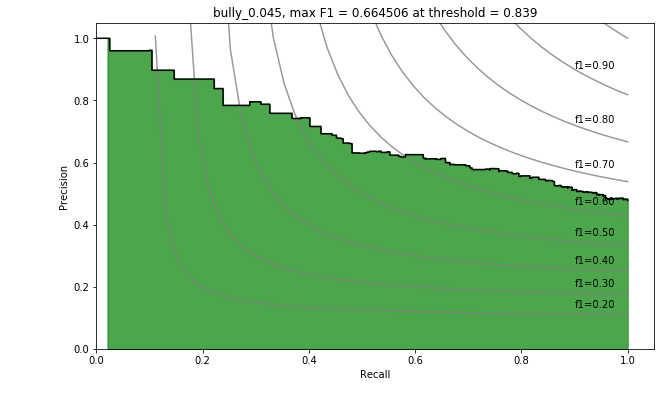

at 0.5
0.9916317991631799
0.48466257668711654

at 0.839
0.8577405857740585
0.5423280423280423


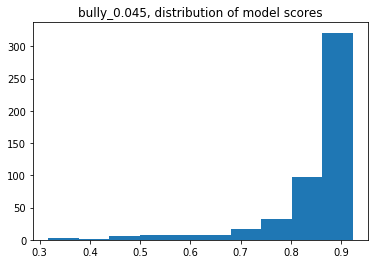

simulations that ended in 'collision'
[  0   1   2   4   5   6   7   9  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  27  28  29  31  33  35  36  38  39  40  41  42  43
  45  46  47  49  50  51  52  54  55  56  57  58  59  60  61  62  64  65
  66  67  68  69  70  71  72  73  75  76  77  78  79  80  82  83  84  85
  87  88  89  90  91  92  93  94  95  96  97  99 100 101 102 105 106 108
 109 110 111 113 114 116 118 119 120 121 122 123 124 125 127 129 131 132
 133 134 135 136 137 138 139 141 142 143 144 146 147 148 149 150 151 152
 153 154 156 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 178 179 180 181 182 184 186 187 188 190 191 192 193 194 195
 196 197 198 199 200 203 204 205 206 207 208 209 210 211 214 215 216 217
 218 220 221 223 224 225 226 227 228 229 231 232 233 234 235 236 237 238
 239 240 241 243 244 245 246 247 248 250 251 252 253 254 255 257 258 260
 261 262 263 264 266 267 269 270 271 272 273 274 275 277 278 280 281 282
 283 284 285 

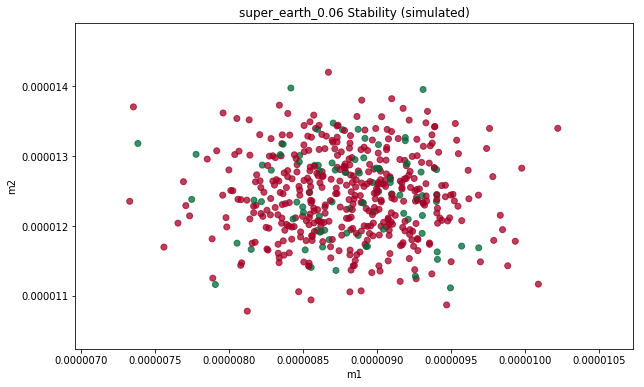

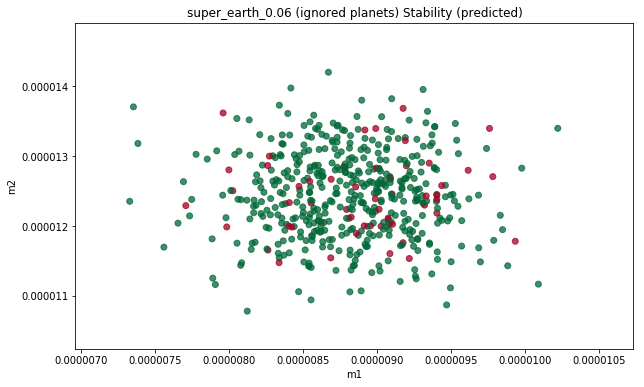

amount of simulated unstable systems
417
amount of predicted unstable systems
55


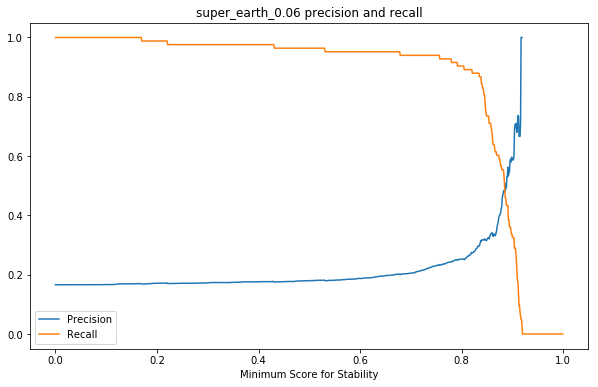

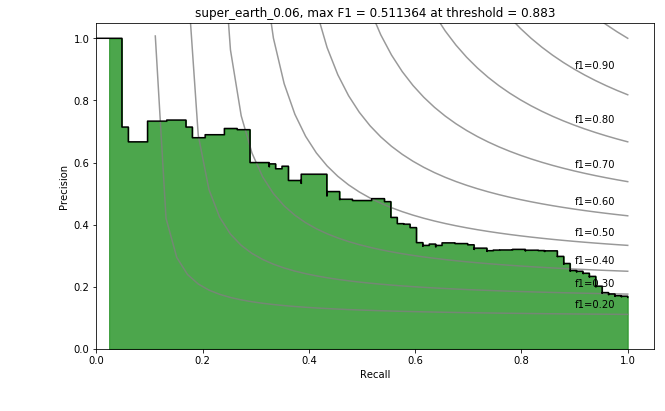

at 0.5
0.963855421686747
0.1797752808988764

at 0.883
0.5421686746987951
0.4838709677419355


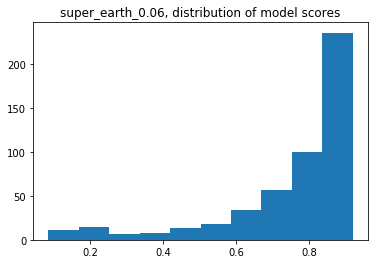

simulations that ended in 'collision'
[  3   5   6   7   9  11  12  16  18  19  20  21  22  24  26  29  30  31
  32  33  34  36  41  42  46  48  50  51  52  54  55  56  58  60  63  64
  66  67  69  70  73  75  76  77  78  82  83  84  86  87  88  90  92  95
  96 100 101 102 103 104 105 106 109 110 112 113 114 115 116 117 119 122
 123 124 125 126 127 128 129 130 131 132 135 136 137 139 141 142 145 146
 147 148 149 151 155 158 160 162 163 166 174 175 177 178 179 180 181 182
 183 184 185 186 194 195 196 198 199 203 205 206 207 208 209 210 212 215
 217 222 224 226 227 229 233 235 237 238 239 240 244 245 246 247 248 249
 250 251 252 253 255 260 261 265 266 267 268 269 270 272 273 274 275 276
 277 278 279 281 283 284 285 287 288 289 290 291 292 293 294 295 297 298
 299 300 305 306 307 309 311 312 314 315 317 318 320 321 324 325 327 328
 333 334 336 337 338 339 343 345 350 351 352 353 355 357 358 360 361 362
 363 366 367 368 370 372 373 374 376 377 378 379 383 384 385 386 388 389
 391 393 394 

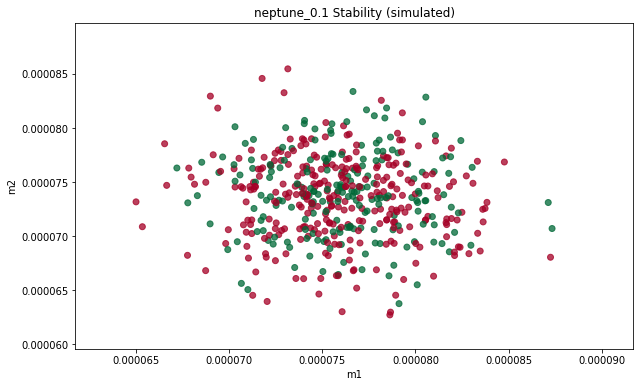

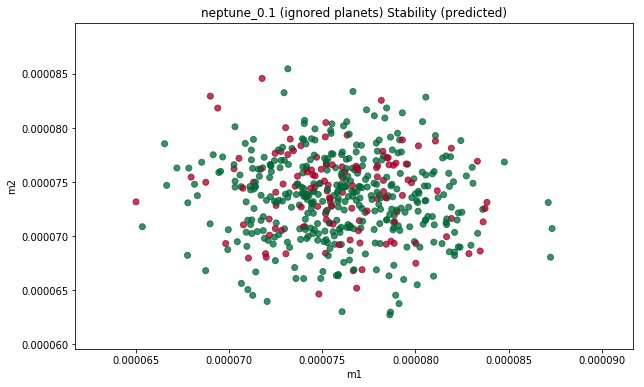

amount of simulated unstable systems
300
amount of predicted unstable systems
119


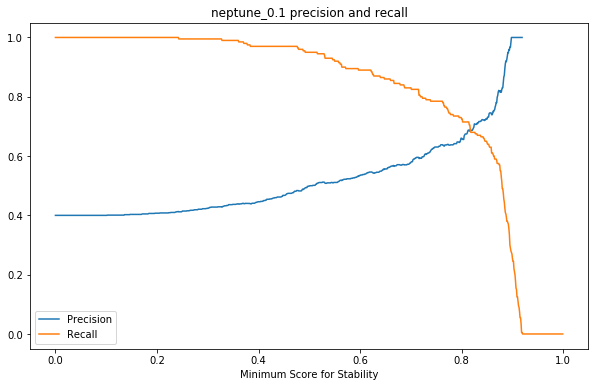

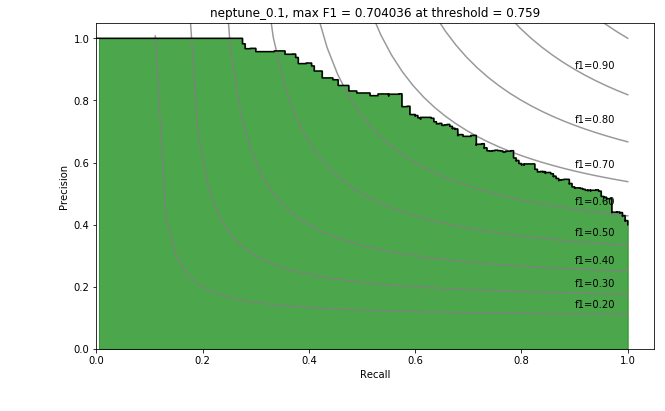

at 0.5
0.95
0.49868766404199477

at 0.759
0.785
0.6382113821138211


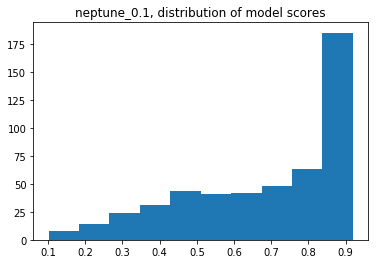

simulations that ended in 'collision'
[  4   5   6  13  16  19  21  22  23  26  27  29  30  31  33  36  39  40
  42  49  51  54  55  56  58  59  62  64  65  69  70  72  78  79  81  83
  87  99 103 108 109 114 119 120 125 126 132 135 136 141 147 148 150 151
 153 156 160 162 163 168 172 176 177 181 184 186 187 188 198 200 202 205
 208 210 211 216 219 223 224 226 232 235 236 239 240 241 244 246 248 249
 252 256 257 258 259 260 263 270 271 273 277 278 285 287 291 292 295 296
 298 305 306 309 311 312 315 321 322 323 326 328 335 336 337 343 347 352
 353 354 358 360 363 364 367 369 370 372 373 378 379 382 384 385 388 391
 395 401 402 403 404 405 406 413 414 417 418 423 426 428 429 430 432 437
 439 443 444 445 446 450 451 453 455 456 459 460 462 463 465 469 470 474
 475 477 479 483 485 491 496 497 498]
simulations that were predicted to end in 'collision'
[  7  17  31  33  39  51  55  74  78  79 100 106 108 119 120 126 130 135
 144 152 165 184 186 216 217 219 220 223 224 232 235 248 256 271 27

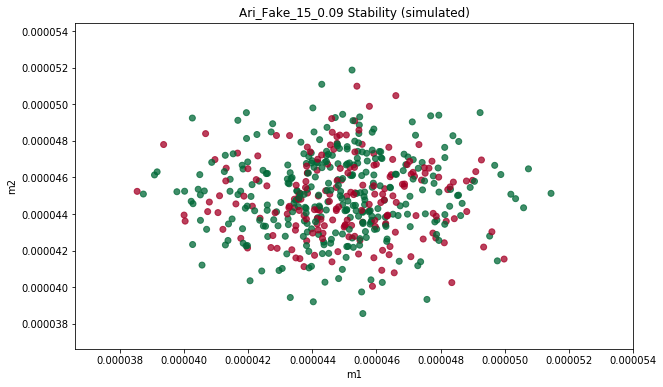

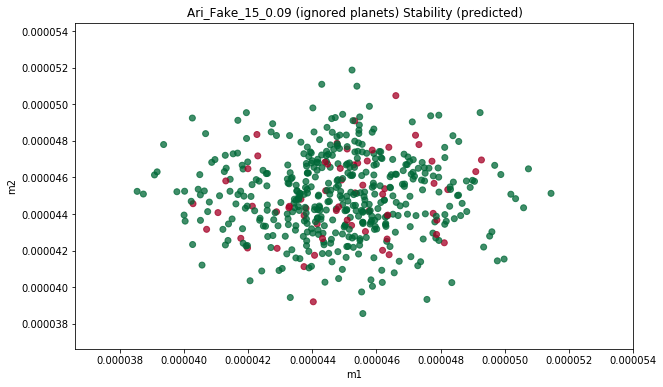

amount of simulated unstable systems
189
amount of predicted unstable systems
61


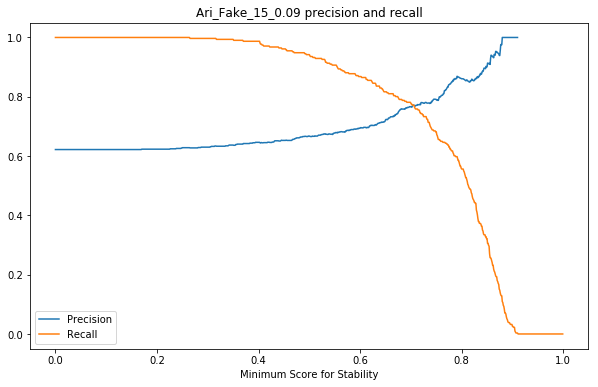

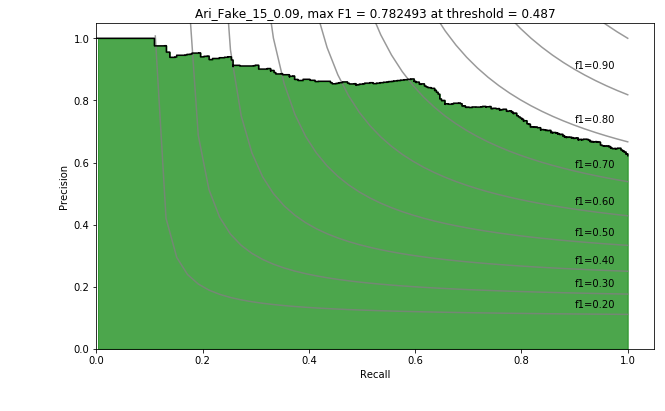

at 0.5
0.9421221864951769
0.6674259681093394

at 0.487
0.9485530546623794
0.6659142212189616


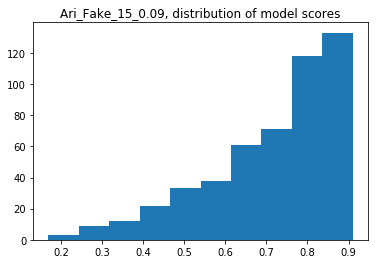

simulations that ended in 'collision'
[  0   1   2   6   7  11  12  14  16  18  22  24  26  27  29  32  35  36
  38  41  42  44  45  48  50  51  54  55  56  57  58  60  61  62  64  65
  68  69  71  75  82  83  84  87  88  89  90  94  95  98 100 101 104 105
 108 111 112 117 119 120 122 124 129 131 133 135 136 139 140 142 144 146
 147 149 150 151 152 154 155 157 161 165 166 171 172 174 176 178 180 182
 188 190 192 197 199 201 202 207 208 210 211 212 213 214 215 217 224 226
 229 230 234 236 237 240 242 244 248 249 257 259 263 265 267 268 273 276
 278 281 284 289 290 291 292 294 295 296 297 299 300 301 302 303 304 306
 308 310 312 313 314 318 324 325 328 330 331 334 335 339 340 344 348 350
 352 353 355 356 357 358 359 360 363 365 366 367 369 370 371 373 376 379
 384 386 387 389 390 393 394 395 397 398 401 402 403 405 406 407 408 409
 412 414 415 417 418 420 421 426 433 434 437 439 442 443 448 450 459 462
 463 464 466 468 469 477 483 485 487 491 492 493 494 496 497 499]
simulations that wer

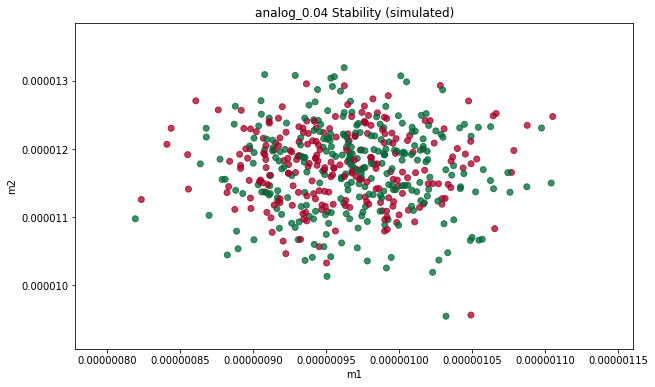

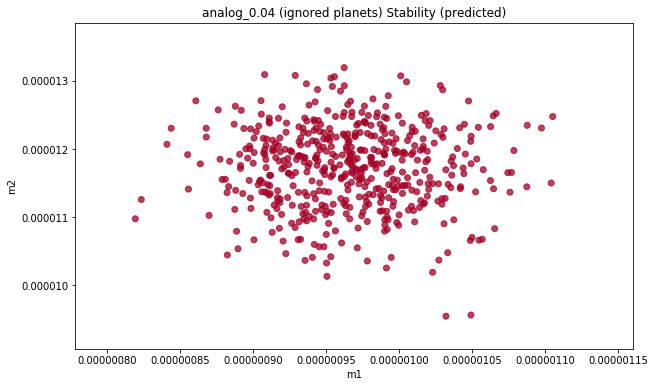

amount of simulated unstable systems
232
amount of predicted unstable systems
0


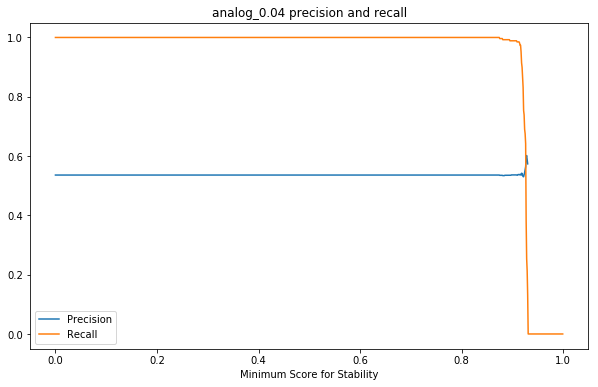

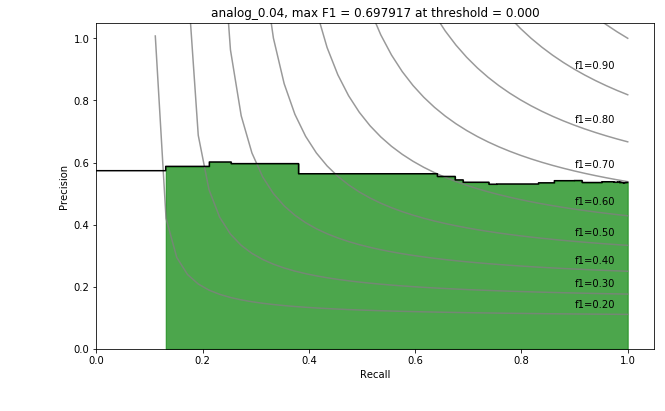

at 0.5
1.0
0.536

at 0.000
1.0
0.536


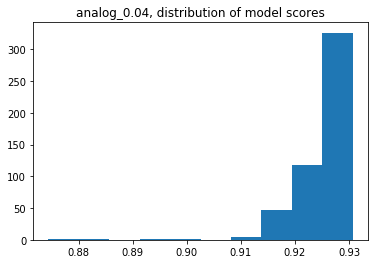

simulations that ended in 'collision'
[  0   1   2   6   7   8   9  12  14  15  18  19  20  21  22  26  27  29
  31  32  34  44  47  48  52  55  57  59  61  63  66  67  71  73  76  77
  81  82  83  85  86  87  91  93  94  96  99 103 105 106 108 110 115 116
 117 118 119 122 123 127 129 132 133 134 136 140 141 143 144 145 146 147
 148 150 151 153 155 156 159 164 166 167 169 171 172 173 177 179 180 181
 182 184 188 190 191 197 199 201 204 205 207 208 209 211 213 214 215 217
 218 219 220 222 223 229 230 231 236 238 240 242 243 244 245 246 247 248
 253 255 256 257 258 260 261 262 263 264 265 266 267 269 270 271 273 275
 276 277 279 289 291 293 297 298 301 302 303 306 307 308 310 312 315 317
 318 320 321 323 329 334 335 336 337 341 345 346 347 348 349 352 355 356
 357 358 359 360 363 364 365 366 367 371 374 376 377 378 382 383 385 387
 388 389 391 392 394 395 396 397 398 400 403 404 405 407 409 411 412 413
 414 416 418 419 420 421 422 425 426 427 429 430 431 435 436 437 439 443
 446 447 451 

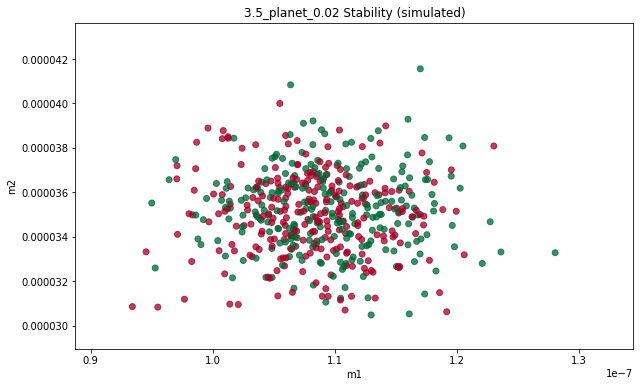

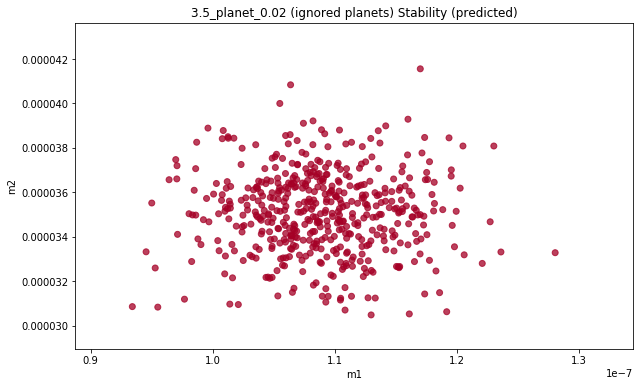

amount of simulated unstable systems
258
amount of predicted unstable systems
0


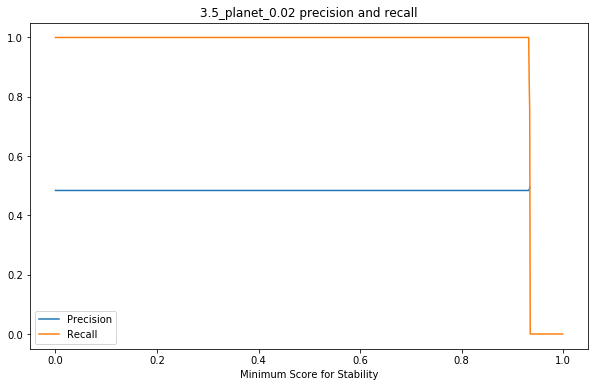

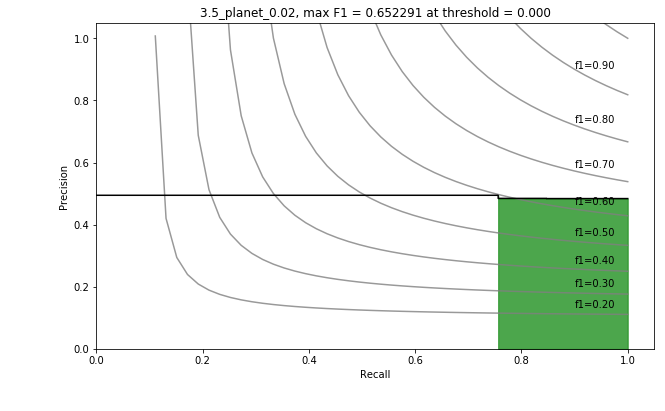

at 0.5
1.0
0.484

at 0.000
1.0
0.484


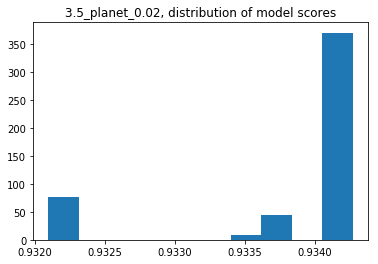

In [14]:
Np=4
testlen=500
fine=1000

systems = ["bully 0.045", "super earth 0.06", "neptune 0.1", "Ari Fake 15 0.09", "analog 0.04", "3.5 planet 0.02"]
for system in systems:
    system = system.replace(" ","_")

    predictionstotal = np.zeros((Np,testlen))
    for i in range(4):
        dataset = pd.read_csv("features/"+system+'_i%d_features.csv'%(i+1))
        X=xgb.DMatrix(dataset[feature_list])
        model = pickle.load(open("final_Naireen2018.pkl", "rb"))
        predictionstotal[i,:] = model.predict(X)

    #trying to predict as many unstable systems as possible (take lowest score of the four)
    predictions=np.min(predictionstotal,axis=0)
    
    data=pd.read_csv("systems/"+system+"_Nbodyresults.csv",header=None)
    stable=np.ones(testlen)
    m1=np.zeros(testlen)
    m2=np.zeros(testlen)
    for i in range(testlen):
        id_ = int(i)
        name = system+"_"+str(id_)
        sa = rebound.SimulationArchive('output/%s/%s_SA.bin'%(system,name))
        sim0 = sa[0]
        m1[i]=sim0.particles[1].m
        m2[i]=sim0.particles[2].m
        #the final collision status of the simulation is taken from a data file
        try:
            stable[i]=1-data[7][np.where(data[0]==name)[0][0]]
        #if not found for some reason, do it the old fashioned way
        except:
            if len(sa)>999:
                stable[i]=1
            else:
                stable[i]=0
        del sa
                
                    
    stable=np.array(stable, dtype=bool)
    stablepred=predictions>0.5
    collide=np.unique(np.where(~stable))
    print("simulations that ended in 'collision'")
    print(collide)
    collidepred=np.unique(np.where(~stablepred))
    print("simulations that were predicted to end in 'collision'")
    print(collidepred)


    color = 1*stable
    colorpred = 1*stablepred

    plt.figure(figsize=(10,6))
    plt.scatter(m1,m2,c=color,alpha=0.75,cmap="RdYlGn")
    plt.xlabel("m1")
    plt.ylabel("m2")
    plt.title("%s Stability (simulated)"%(system))
    plt.xlim(0.95*min(m1),1.05*max(m1))
    plt.ylim(0.95*min(m2),1.05*max(m2))
    plt.show()

    plt.figure(figsize=(10,6))
    plt.scatter(m1,m2,c=colorpred,alpha=0.75,cmap="RdYlGn")
    plt.xlabel("m1")
    plt.ylabel("m2")
    plt.title("%s (ignored planets) Stability (predicted)"%(system))
    plt.xlim(0.95*min(m1),1.05*max(m1))
    plt.ylim(0.95*min(m2),1.05*max(m2))
    plt.show()

    print("amount of simulated unstable systems")
    print(sum(~stable))
    print("amount of predicted unstable systems")
    print(sum(~stablepred))
    
    precision=np.zeros(fine)
    recall=np.zeros(fine)
    x=np.arange(fine)/fine
    f1=np.zeros(fine)
    for i in range(fine):
        stablepred=predictions>x[i]
        tp = stablepred & stable
        precision[i] = sum(tp)/sum(stablepred)
        recall[i] = sum(tp)/sum(stable)
        f1[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])

    maxf1 = max(f1[~np.isnan(f1)])
    maxthreshold= x[np.where(f1==maxf1)][0]
    plt.figure(figsize=(10,6))
    line1,=plt.plot(x,precision)
    line2,=plt.plot(x,recall)
    plt.xlabel("Minimum Score for Stability")
    #plt.ylabel("m2")
    plt.title("%s precision and recall"%(system))
    plt.legend([line1, line2], ["Precision", "Recall"])
    plt.show()

    plt.figure(figsize=(10,6))

    f_scores = np.linspace(0.2, 1.0, num=9)
    for f_score in f_scores:
        xf1 = np.linspace(0.01, 1)
        yf1 = f_score * xf1 / (2 * xf1 - f_score)
        l, = plt.plot(xf1[yf1 >= 0], yf1[yf1 >= 0], color='grey', alpha=0.8)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, yf1[45] + 0.02))

    plt.step(recall,precision, color='black', where='post')
    plt.fill_between(recall,precision, step='post', alpha=0.7,color='g')
    #plt.plot(precision,recall)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0,1.05)
    plt.ylim(0,1.05)
    plt.title("%s, max F1 = %f at threshold = %1.3f"%(system, maxf1,maxthreshold))
    #plt.legend([line1, line2], ["Precision", "Recall"])
    plt.show()

    print("at 0.5")
    print(recall[int(fine/2)])
    print(precision[int(fine/2)])
    print()
    print("at %1.3f" % maxthreshold)
    print(recall[int(fine*maxthreshold)])
    print(precision[int(fine*maxthreshold)])
    
    plt.hist(predictions)
    plt.title("%s, distribution of model scores"%(system))
    plt.show()
    